In [3]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.7* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU). 


In [1]:
using Pkg
Pkg.add(["PyPlot", "SparseArrays"])
using PyPlot, SparseArrays


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Reexport ────────── v1.2.2
   Installed LaTeXStrings ────── v1.3.0
   Installed PyPlot ──────────── v2.11.0
   Installed FixedPointNumbers ─ v0.8.4
   Installed ColorTypes ──────── v0.11.4
   Installed MacroTools ──────── v0.5.10
   Installed PyCall ──────────── v1.94.1
   Installed Colors ──────────── v0.12.8
    Updating `~/.julia/environments/v1.7/Project.toml`
  [d330b81b] + PyPlot v2.11.0
  [2f01184e] + SparseArrays
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [3da002f7] + ColorTypes v0.11.4
  [5ae59095] + Colors v0.12.8
  [53c48c17] + FixedPointNumbers v0.8.4
  [b964fa9f] + LaTeXStrings v1.3.0
  [1914dd2f] + MacroTools v0.5.10
  [438e738f] + PyCall v1.94.1
  [d330b81b] + PyPlot v2.11.0
  [189a3867] + Reexport v1.2.2
  [37e2e46d] + LinearAlgebra
  [2f01184e] + SparseArrays
  [10745b16] + Statistics
  [e66e0078] + CompilerSupportLibraries_jll
  [4536629a] + OpenBLA

Now you can start writing Julia code below!


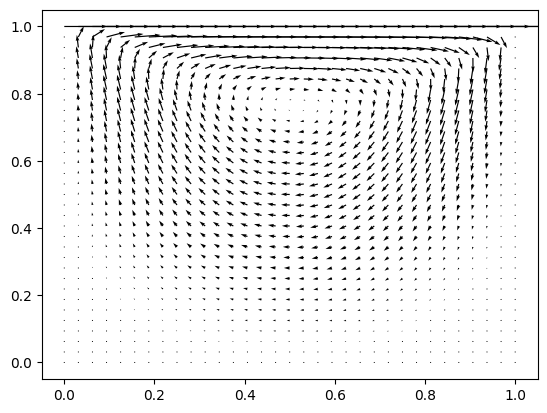

PyObject <matplotlib.quiver.Quiver object at 0x7ff177650f50>

In [2]:
# Driven Cavity by +e MAC Me+od

# Initialize Grid Size
xGrid = 32
yGrid = 32

# Initialize Computational Domain
Lx = 1.0
Ly = 1.0

MaxStep = 500
Visc = 0.1
rho = 1.0

# Initialize Parameters for SOR
MaxIt = 100
Beta = 1.5
MaxErr = 0.001

# Dimensions of the control volume in x and y directions
Δx = Lx / xGrid
Δy = Ly / yGrid

# Boundary conditions
un = 1 # u-north 
us = 0 # u-south
ve = 0 # v-east 
vw = 0 # v-west

# Initialize time variables
time = 0.0
Δt = 0.002

u = zeros(xGrid + 1, yGrid + 2)
v = zeros(xGrid + 2, yGrid + 1)
uu = zeros(xGrid + 1, yGrid + 1)
vv = zeros(xGrid + 1, yGrid + 1)
p = zeros(xGrid + 2, yGrid + 2)
ut = zeros(xGrid + 1, yGrid + 2)
vt = zeros(xGrid + 2, yGrid + 1)
pold = zeros(xGrid + 2, yGrid + 2)

# initial conditions for pressure
c = zeros(xGrid + 1, yGrid + 2) .+ 1 / (2 / Δx^2 + 2 / Δy^2)
c[2, 3:yGrid] .= 1 / (1 / Δx^2 + 2 / Δy^2)
c[xGrid+1, 3:yGrid] .= 1 / (1 / Δx^2 + 2 / Δy^2)
c[3:xGrid, 2] .= 1 / (1 / Δx^2 + 2 / Δy^2)
c[3:xGrid, yGrid+1] .= 1 / (1 / Δx^2 + 2 / Δy^2)
c[2, 2] = 1 / (1 / Δx^2 + 1 / Δy^2)
c[2, yGrid+1] = 1 / (1 / Δx^2 + 1 / Δy^2)
c[xGrid+1, 2] = 1 / (1 / Δx^2 + 1 / Δy^2)
c[xGrid+1, yGrid+1] = 1 / (1 / Δx^2 + 1 / Δy^2)

# grid points
x = zeros(Float64, xGrid + 1, yGrid + 1)
y = zeros(Float64, xGrid + 1, yGrid + 1)

# Fill in the grid points 
for i = 1:xGrid+1
    for j = 1:yGrid+1
        x[i, j] = Δx * (i - 1)
        y[i, j] = Δy * (j - 1)
    end
end


for is = 1:MaxStep
    # assign boundary conditions
    u[1:xGrid+1, 1] .= (2 * us .- u[1:xGrid+1, 2])
    u[1:xGrid+1, yGrid+2] .= (2 * un .- u[1:xGrid+1, yGrid+1])
    v[1, 1:yGrid+1] .= (2 * vw .- v[2, 1:yGrid+1])
    v[xGrid+2, 1:yGrid+1] .= (2 * ve .- v[xGrid+1, 1:yGrid+1])

    for i = 2:xGrid # temporary u-velocity
        for j = 2:yGrid+1
            ut[i, j] = u[i, j] + Δt * (-0.25 * (
                ((u[i+1, j] + u[i, j])^2 - (u[i, j] + u[i-1, j])^2) / Δx + ((u[i, j+1] + u[i, j]) * (v[i+1, j] + v[i, j]) - (u[i, j] + u[i, j-1]) * (v[i+1, j-1] + v[i, j-1])) / Δy) + Visc * ((u[i+1, j] + u[i-1, j] - 2 * u[i, j]) / Δx^2 + (u[i, j+1] + u[i, j-1] - 2 * u[i, j]) / Δy^2))
        end
    end

    for i = 2:xGrid+1 # temporary v-velocity
        for j = 2:yGrid
            vt[i, j] = v[i, j] + Δt * (-0.25 * (((u[i, j+1] + u[i, j]) * (v[i+1, j] + v[i, j]) - (u[i-1, j+1] + u[i-1, j]) * (v[i, j] + v[i-1, j])) / Δx + ((v[i, j+1] + v[i, j])^2 - (v[i, j] + v[i, j-1])^2) / Δy) + Visc * ((v[i+1, j] + v[i-1, j] - 2 * v[i, j]) / Δx^2 + (v[i, j+1] + v[i, j-1] - 2 * v[i, j]) / Δy^2))
        end
    end

    for it = 1:MaxIt # solve for pressure
        global pold = copy(p)

        for i = 2:xGrid+1
            for j = 2:yGrid+1
                p[i, j] = Beta * c[i, j] * ((p[i+1, j] + p[i-1, j]) / Δx^2 + (p[i, j+1] + p[i, j-1]) / Δy^2 - (rho / Δt) * ((ut[i, j] - ut[i-1, j]) / Δx + (vt[i, j] - vt[i, j-1]) / Δy)) + (1 - Beta) * p[i, j]
            end
        end

        Err = 0.0 # check error
        for i = 2:xGrid+1
            for j = 2:yGrid+1
                Err = Err + abs(pold[i, j] - p[i, j])

            end
        end

        if Err <= MaxErr
            break # stop if converged
        end
    end

    # correct +e velocity
    u[2:xGrid, 2:yGrid+1] = ut[2:xGrid, 2:yGrid+1] - (Δt / Δx) * (p[3:xGrid+1, 2:yGrid+1] - p[2:xGrid, 2:yGrid+1]) #FIXME 
    v[2:xGrid+1, 2:yGrid] = vt[2:xGrid+1, 2:yGrid] - (Δt / Δy) * (p[2:xGrid+1, 3:yGrid+1] - p[2:xGrid+1, 2:yGrid])

    global time += Δt # plot +e results
    uu[1:xGrid+1, 1:yGrid+1] = 0.5 * (u[1:xGrid+1, 2:yGrid+2] + u[1:xGrid+1, 1:yGrid+1])
    vv[1:xGrid+1, 1:yGrid+1] = 0.5 * (v[2:xGrid+2, 1:yGrid+1] + v[1:xGrid+1, 1:yGrid+1])

end

quiver(x, y, uu, vv)
